In [12]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import torch
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras import models, layers, callbacks
from keras.utils import plot_model

In [13]:
CONFIG = {
  "dataset_path": "../datasets/",
  "story_path": "../datasets/CBU0521DD_stories/",
  "augmented_story_path": "../datasets/CBU0521DD_stories/_augmented/",
  "label_path": "../datasets/CBU0521DD_stories_attributes.csv",
  "augmented_label_path": "../datasets/CBU0521DD_stories_attributes_augmented.csv",
  "model_path": "../models/",
  "epoch": 100,
  "batch_size": 20,
}

In [14]:
labels_df = pd.read_csv(CONFIG["label_path"])
labels_df.head()

,filename,Language,Story_type
0,00001.wav,Chinese,True Story
1,00002.wav,Chinese,True Story
2,00003.wav,Chinese,True Story
3,00004.wav,Chinese,True Story
4,00005.wav,Chinese,True Story


In [15]:
def extract_features(file_path, sr=16000, n_mels=128, duration=240):
    # 加载音频
    audio, sr = librosa.load(file_path, sr=sr)
    
    # 提取梅尔谱图和对数变换
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    # 提取MFCC
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    
    # 提取Chroma特征
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    
    # 提取时域特征
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    short_term_energy = np.sum(audio ** 2) / len(audio)
    duration_feature = len(audio) / sr  # 音频的时长
    
    # 提取频域特征
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85)
    spectral_flux = librosa.onset.onset_strength(y=audio, sr=sr)
    
    # 拼接所有特征
    features = np.vstack([
        log_mel_spectrogram, mfcc, chroma, zero_crossing_rate,
        spectral_centroid, spectral_rolloff, spectral_flux
    ])
    
    # 填充或裁剪到统一大小
    target_length = int(sr * duration / 512)  # 计算目标时间步数
    if features.shape[1] < target_length:
        padding = np.zeros((features.shape[0], target_length - features.shape[1]))
        features = np.concatenate([features, padding], axis=1)
    else:
        features = features[:, :target_length]
    
    # 添加时域特征，并进行广播匹配时间步数
    additional_features = np.array([short_term_energy, duration_feature])
    additional_features = np.repeat(additional_features[:, np.newaxis], features.shape[1], axis=1)  # 广播
    
    # 拼接时域特征和其他特征
    features = np.concatenate([features, additional_features], axis=0)

    return features

In [16]:
from tqdm import tqdm
# 提取所有音频文件的特征和标签
def load_data(dataset_path, labels_df, augmented=False):
    features = []
    labels = []

    # 如果需要加载增强数据
    if augmented:
        label_file_path = CONFIG['augmented_label_path']
        augmented_labels_df = pd.read_csv(label_file_path)
        filenames = augmented_labels_df['filename'].tolist()
    else:
        filenames = labels_df['filename'].tolist()

    # 使用 tqdm 显示进度条
    for filename in tqdm(filenames, desc="Loading data: ", ncols=100, unit="file"):
        file_path = os.path.join(dataset_path, filename)

        # 提取音频特征
        audio_features = extract_features(file_path)

        # 获取标签：故事的真实性 ("True Story" / "False Story")
        if augmented:
            story_type = augmented_labels_df[augmented_labels_df['filename'] == filename]['Story_type'].values[0]
        else:
            story_type = labels_df[labels_df['filename'] == filename]['Story_type'].values[0]

        # 将特征和标签添加到列表中
        features.append(audio_features)
        labels.append(story_type)

    return np.array(features), np.array(labels)

# 读取标签文件
labels_df = pd.read_csv(CONFIG['label_path'])

# 加载原始数据
original_features, original_labels = load_data(CONFIG['story_path'], labels_df, augmented=False)

# 加载增强数据
augmented_features, augmented_labels = load_data(CONFIG['augmented_story_path'], labels_df, augmented=True)

# 合并原始数据和增强数据
features = np.concatenate((original_features, augmented_features), axis=0)
labels = np.concatenate((original_labels, augmented_labels), axis=0)

# 输出数据集的大小
print(f"Original dataset size: {original_features.shape[0]}, Augmented dataset size: {augmented_features.shape[0]}")
print(f"Combined dataset size: {features.shape[0]}")

Loading data: 100%|█████████████████████████████████████████████| 500/500 [07:21<00:00,  1.13file/s]


Original dataset size: 100, Augmented dataset size: 500
Combined dataset size: 600


In [17]:
# Save features and labels to a .npz file
def save_data(features, labels, file_path):
    np.savez(file_path, features=features, labels=labels)
    print(f"Dataset saved to: {file_path}")

# 加载数据
def load_data_from_npz(file_path):
    data = np.load(file_path)
    return data['features'], data['labels']

In [18]:
save_data(original_features, original_labels, os.path.join(CONFIG["dataset_path"], 'original_data.npz'))
save_data(augmented_features, augmented_labels, os.path.join(CONFIG["dataset_path"],'augmented_data.npz'))
save_data(features, labels, os.path.join(CONFIG["dataset_path"],'data.npz'))

Dataset saved to: ../datasets/original_data.npz
Dataset saved to: ../datasets/augmented_data.npz
Dataset saved to: ../datasets/data.npz


In [24]:
# 使用LabelEncoder将文本标签转化为数值标签
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# 查看编码后的标签
print("Encoded labels:", labels_encoded)

Encoded labels: [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 1
 0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0
 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1
 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0
 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0
 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 

In [29]:
# First split: 70% training, 30% temporary (to be split further)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels_encoded, test_size=0.3, random_state=42)

# Second split: 50% of the 30% temporary set to validation and test (15% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Output the size of each dataset
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

Training set size: 420
Validation set size: 90
Test set size: 90


In [31]:
X_train.shape

(420, 166, 7500, 1)

In [32]:
def build_model(input_shape):
    model_input = layers.Input(shape=input_shape)

    # 卷积层部分 - 提取局部特征
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    # 注意力机制
    # 调整为 3D 张量
    x = layers.Reshape((1, 128))(x)  # (batch_size, sequence_length=1, feature_dim=128)
    attention_output = layers.Attention()([x, x])  # Self-attention

    # LSTM 层部分 - 捕获时间序列特征
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(attention_output)
    x = layers.Bidirectional(layers.LSTM(64))(x)

    # 全连接层部分 - 分类任务
    x = layers.Dense(64, activation='relu', kernel_regularizer='l2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    # 构建模型
    model = models.Model(inputs=model_input, outputs=output)

    # 编译模型
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [33]:
def show_history(history):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [35]:
def train_multiple_cnn_lstm_models(X_train, y_train, X_val, y_val, n_models=3, continue_training=False):
    models_list = [models.load_model(os.path.join(CONFIG['model_path'], f'best_model_{i + 1}.keras')) for i in range(n_models)] if continue_training else []
    for i in range(n_models):
        # First split: 70% training, 30% temporary (to be split further)
        X_train, X_temp, y_train, y_temp = train_test_split(features, labels_encoded, test_size=0.3, random_state=42)

        # Second split: 50% of the 30% temporary set to validation and test (15% each)
        X_val, _, y_val, _ = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
        
        X_train = X_train[..., np.newaxis]
        X_val = X_val[..., np.newaxis]
        
        print(f"Training Model {i + 1}")
        model = build_model((X_train.shape[1], X_train.shape[2], X_train.shape[3])) if not continue_training else models_list[i]

        # 设置callbacks来监控每个模型的训练过程
        early_stopping = callbacks.EarlyStopping(monitor='loss', patience=100)
        model_checkpoint = callbacks.ModelCheckpoint(
            filepath=os.path.join(CONFIG['model_path'], f'best_model_{i + 1}.keras'),
            monitor='val_accuracy',
            save_best_only=True
        )
        callbacks_list = [early_stopping, model_checkpoint]

        history = model.fit(X_train, y_train, epochs=CONFIG["epoch"], batch_size=CONFIG["batch_size"], validation_data=(X_val, y_val), callbacks=callbacks_list)
        show_history(history)
        models_list.append(model)
    return models_list

Training Model 1


2024-12-20 18:30:06.109438: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 18:30:06.115198: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 18:30:06.125920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734690606.144581   18710 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734690606.150455   18710 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regist

Epoch 1/100


/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([20, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 658ms/step - accuracy: 0.5531 - loss: 1.5044 - val_accuracy: 0.4667 - val_loss: 1.3461
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 731ms/step - accuracy: 0.5613 - loss: 1.3038 - val_accuracy: 0.4667 - val_loss: 1.1905
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 646ms/step - accuracy: 0.5946 - loss: 1.1367 - val_accuracy: 0.4667 - val_loss: 1.0733
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 662ms/step - accuracy: 0.5844 - loss: 1.0281 - val_accuracy: 0.4917 - val_loss: 0.9844
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 729ms/step - accuracy: 0.6406 - loss: 0.9102 - val_accuracy: 0.4667 - val_loss: 0.9170
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 677ms/step - accuracy: 0.6189 - loss: 0.8612 - val_accuracy: 0.4667 - val_loss: 0.8686
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 718ms/step - accuracy: 0.6034 - loss: 0.8091 - val_accuracy: 0.4750 - val_loss: 0.8302
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 733ms/step - accuracy: 0.5795 - loss: 0.7952 - val_accuracy

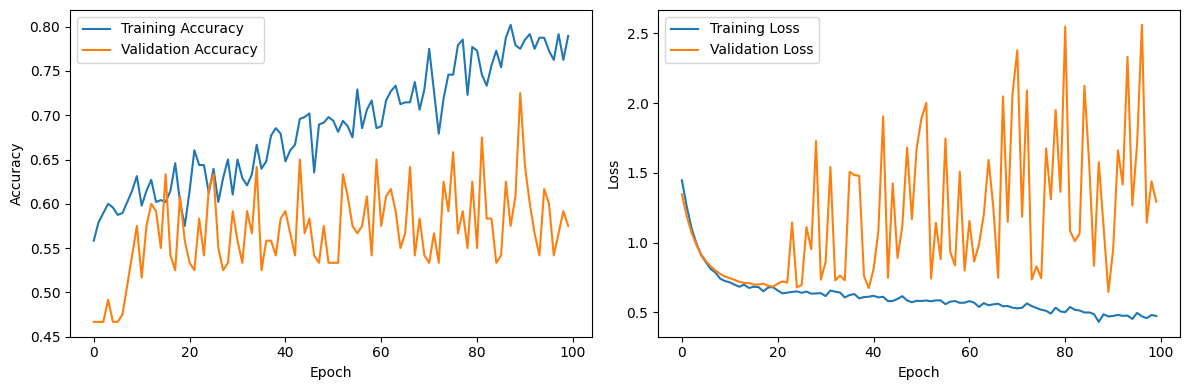

Model 1 training complete.


In [12]:
# 训练多个CNN-LSTM模型
models_list = train_multiple_cnn_lstm_models(X_train, y_train, X_val, y_val, n_models=1, continue_training=False)

# 输出：显示每个模型的训练过程
for i, model in enumerate(models_list):
    print(f"Model {i + 1} training complete.")

In [27]:
# 训练一个随机森林模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

RandomForestClassifier(random_state=42)

In [14]:
def ensemble_predict(models_list, rf_model, X_test, weights=None):
    # CNN-LSTM 模型预测
    nn_preds = np.zeros((len(models_list), X_test.shape[0]))
    for i, model in enumerate(models_list):
        nn_preds[i] = model.predict(X_test).flatten()

    # 随机森林模型预测
    rf_preds = rf_model.predict_proba(X_test.reshape(X_test.shape[0], -1))[:, 1]

    # 加权投票
    if weights is None:
        weights = [1 / len(models_list)] * len(models_list)  # 默认等权重
    nn_pred_avg = np.average(nn_preds, axis=0, weights=weights)
    
    # 最终预测
    final_pred_prob = (nn_pred_avg + rf_preds) / 2
    final_pred = (final_pred_prob > 0.5).astype(int)
    
    return final_pred

In [15]:
# 预测并评估集成模型的效果
final_pred = ensemble_predict(models_list, rf_model, X_test)
ensemble_accuracy = accuracy_score(y_test, final_pred)
print(f"Ensemble Model Test Accuracy: {ensemble_accuracy}")

# 输出预测结果与真实标签
predicted_labels = label_encoder.inverse_transform(final_pred)
true_labels = label_encoder.inverse_transform(y_test)
for true, pred in zip(true_labels, predicted_labels):
    print(f"Actual: {true}, Predicted: {pred}")

1/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([32, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([24, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step
Ensemble Model Test Accuracy: 0.6583333333333333
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: True Story
Actual: Deceptive Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: True

In [19]:
def load_models(models_path, n_models):
    models_list = []
    for i in range(n_models):
        model = models.load_model(os.path.join(models_path, f'best_model_{i + 1}.keras'))
        models_list.append(model)
    return models_list

In [20]:
models_list = load_models(CONFIG['model_path'], 1)

2024-12-23 12:01:54.091442: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-23 12:01:54.098120: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-23 12:01:54.113200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734926514.138568    1487 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734926514.146092    1487 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regist

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# 计算其他评估指标
def evaluate_model(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    print("Classification Report:\n", report)

    # 计算 Sensitivity, Specificity, Precision, F1 Score 等指标
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    sensitivity = TP / (TP + FN)  # True Positive Rate
    specificity = TN / (TN + FP)  # True Negative Rate
    precision = TP / (TP + FP)  # Precision
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)  # F1 Score

    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

# 绘制ROC曲线（通过不同阈值生成混淆矩阵）
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

    # 计算 AUC
    roc_auc = auc(fpr, tpr)

    # 绘制 ROC 曲线
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')

    # 绘制随机分类器的基线
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

    # 设置图形标题和标签
    plt.xlabel('1 - Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('Receiver Operating Characteristic (ROC) Curve with Cost Ratio')
    plt.legend(loc='lower right')
    plt.show()

# 对于集成模型进行评估
def evaluate_ensemble_model(y_true, models_list, rf_model, X_test):
    # 获取CNN-LSTM模型的预测概率
    nn_preds_prob = np.zeros((len(models_list), X_test.shape[0]))
    for i, model in enumerate(models_list):
        nn_preds_prob[i] = model.predict(X_test).flatten()

    # 获取随机森林模型的预测概率
    rf_preds_prob = rf_model.predict_proba(X_test.reshape(X_test.shape[0], -1))[:, 1]

    # 计算加权平均的预测概率
    nn_pred_avg = np.mean(nn_preds_prob, axis=0)
    final_pred_prob = (nn_pred_avg + rf_preds_prob) / 2

    # 生成最终的预测标签
    final_pred = (final_pred_prob > 0.5).astype(int)

    # 评估结果
    print("\nEnsemble Model Evaluation:")
    evaluate_model(y_true, final_pred)
    plot_confusion_matrix(y_true, final_pred, labels=['False Story', 'True Story'])
    plot_roc_curve(y_true, final_pred_prob)
    
    return final_pred, final_pred_prob

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([32, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([26, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 483ms/step

Ensemble Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.94      0.96      0.95        48

    accuracy                           0.94        90
   macro avg       0.94      0.94      0.94        90
weighted avg       0.94      0.94      0.94        90

Sensitivity: 0.96
Specificity: 0.93
Precision: 0.94
F1 Score: 0.95


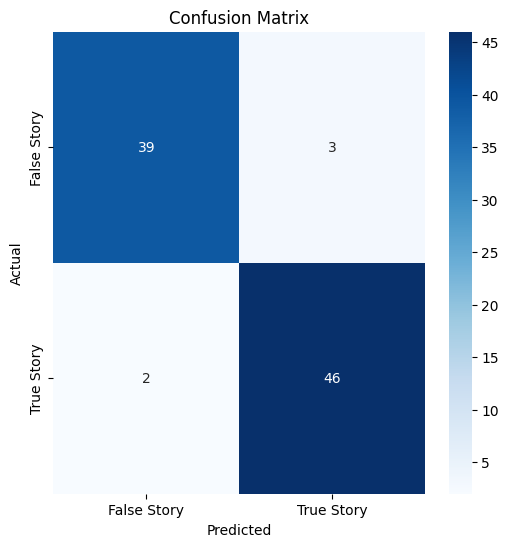

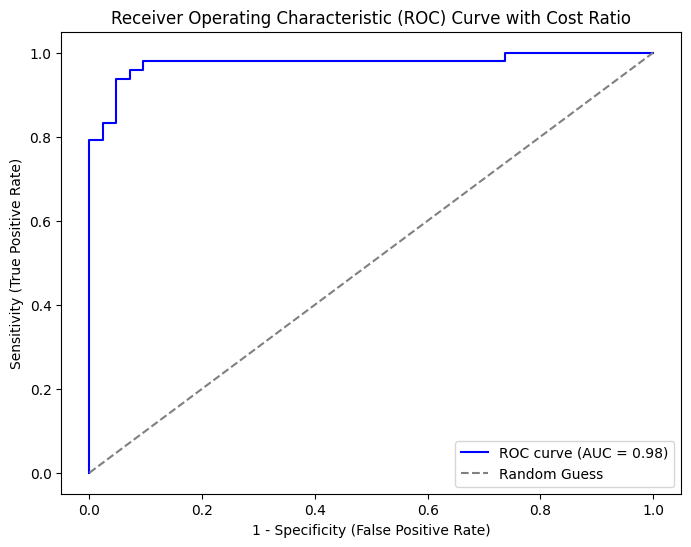

Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: True Story
Actual: Deceptive 

In [30]:
# 评估集成模型
final_pred, final_pred_prob = evaluate_ensemble_model(y_test, models_list, rf_model, X_test)

# 输出预测结果与真实标签
predicted_labels = label_encoder.inverse_transform(final_pred)
true_labels = label_encoder.inverse_transform(y_test)
for true, pred in zip(true_labels, predicted_labels):
    print(f"Actual: {true}, Predicted: {pred}")

In [21]:
plot_model(models_list[0], show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
